### Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import librosa
from moviepy.editor import VideoFileClip, AudioFileClip
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import AudioFileClip, VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

### Generate Video Simulation of Lighting Program

Moviepy - Building video time_traveler_simulation.mp4.
MoviePy - Writing audio in time_traveler_simulationTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video time_traveler_simulation.mp4



Moviepy - Done !
Moviepy - video ready time_traveler_simulation.mp4


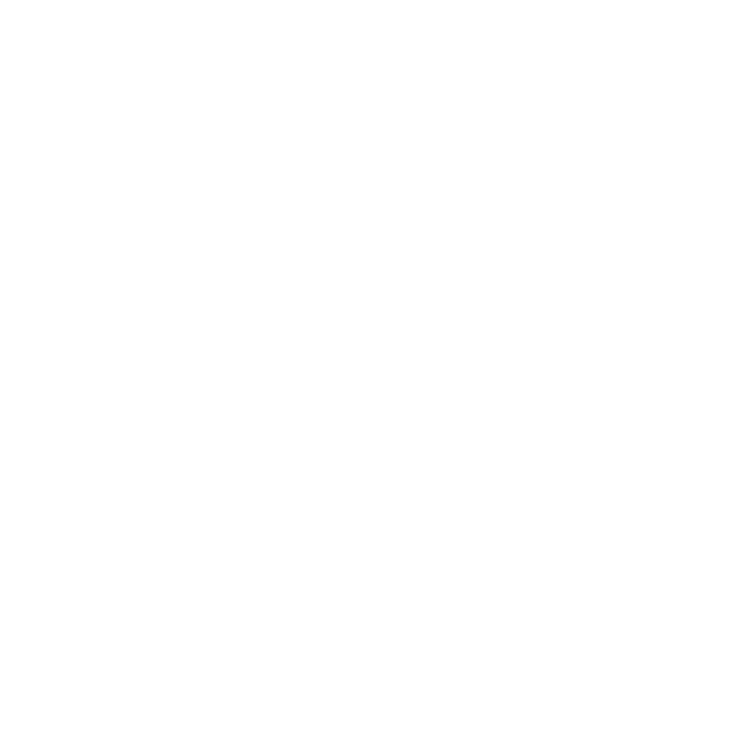

In [2]:
audio_path = 'time_traveler.mp3'
y, sr = librosa.load(audio_path, sr=None)

# Parameters
n_fft = 2048
hop_length = 512
fps = 60
duration = librosa.get_duration(y=y, sr=sr)
frames = int(duration * fps)

# Compute STFT, RMS energy, and spectral centroid
stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
rms_energy = librosa.feature.rms(S=stft).flatten()
spectral_centroid = librosa.feature.spectral_centroid(S=stft, sr=sr).flatten()

# Normalize RMS energy and spectral centroid
rms_energy /= rms_energy.max()
spectral_centroid /= spectral_centroid.max()

# Define sub-bands for bass, midtones, and treble (4 bands each)
bass_limits = np.linspace(20, 250, 5)
mid_limits = np.linspace(250, 2000, 5)
treble_limits = np.linspace(2000, 8000, 5)

# Compute onset strengths in each sub-band
bass_onsets = [
    librosa.onset.onset_strength(y=y, sr=sr, S=stft[(frequencies >= bass_limits[i]) & (frequencies < bass_limits[i+1]), :], hop_length=hop_length)
    for i in range(4)
]
mid_onsets = [
    librosa.onset.onset_strength(y=y, sr=sr, S=stft[(frequencies >= mid_limits[i]) & (frequencies < mid_limits[i+1]), :], hop_length=hop_length)
    for i in range(4)
]
treble_onsets = [
    librosa.onset.onset_strength(y=y, sr=sr, S=stft[(frequencies >= treble_limits[i]) & (frequencies < treble_limits[i+1]), :], hop_length=hop_length)
    for i in range(4)
]

# Normalize onset strengths to [0, 1] for brightness
bass_onsets = [onset / np.max(onset) if np.max(onset) > 0 else onset for onset in bass_onsets]
mid_onsets = [onset / np.max(onset) if np.max(onset) > 0 else onset for onset in mid_onsets]
treble_onsets = [onset / np.max(onset) if np.max(onset) > 0 else onset for onset in treble_onsets]

# LED configuration
led_positions = [(np.cos(2 * np.pi * i / 12), np.sin(2 * np.pi * i / 12)) for i in range(12)]
colors = ['red'] * 4 + ['green'] * 4 + ['blue'] * 4

# Initialize the plot
fig, ax = plt.subplots(figsize=(9.5, 9.5), dpi=100)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis("off")

# Initialize LED circles
led_circles = [Circle(pos, 0.1) for pos in led_positions]
for color, circle in zip(colors, led_circles):
    circle.set_facecolor(color)
    ax.add_patch(circle)

# Parameters for smooth transitions and scaling
smoothing_alpha = 0.8  # Smoothing factor for exponential moving average
previous_brightness = [0] * 12  # Initialize brightness history for smoothing
low_energy_threshold = 0.55  # Threshold for applying smoothing

# Function to apply logarithmic scaling
def log_scale(x, factor=4):
    return np.log1p(x * factor)# / np.log1p(factor)

# Function to draw each frame
def make_frame(t):
    frame_idx = int(t * fps)
    onset_idx = int(t * sr / hop_length)

    # Adjust brightness scaling with energy and spectral centroid
    energy_scale = rms_energy[onset_idx] if onset_idx < len(rms_energy) else 0.5
    centroid_scale = spectral_centroid[onset_idx] if onset_idx < len(spectral_centroid) else 0.5
    brightness_scale = log_scale(energy_scale * 0.8 + centroid_scale * 0.4)

    # Update LED brightness based on onset strength with additional scaling and conditional smoothing
    for i in range(4):
        # Bass (red LEDs)
        bass_alpha = bass_onsets[i][onset_idx] if onset_idx < len(bass_onsets[i]) else 0
        target_brightness = log_scale(bass_alpha * brightness_scale)

        # Apply smoothing only if in a low-energy section
        if energy_scale < low_energy_threshold:
            smoothed_brightness = smoothing_alpha * previous_brightness[i] + (1 - smoothing_alpha) * target_brightness
        else:
            smoothed_brightness = target_brightness  # No smoothing for high-energy sections

        led_circles[i].set_alpha(min(1, smoothed_brightness))
        previous_brightness[i] = smoothed_brightness

        # Midtones (green LEDs)
        mid_alpha = mid_onsets[i][onset_idx] if onset_idx < len(mid_onsets[i]) else 0
        target_brightness = log_scale(mid_alpha * brightness_scale)
        if energy_scale < low_energy_threshold:
            smoothed_brightness = smoothing_alpha * previous_brightness[i + 4] + (1 - smoothing_alpha) * target_brightness
        else:
            smoothed_brightness = target_brightness

        led_circles[i + 4].set_alpha(min(1, smoothed_brightness))
        previous_brightness[i + 4] = smoothed_brightness

        # Treble (blue LEDs)
        treble_alpha = treble_onsets[i][onset_idx] if onset_idx < len(treble_onsets[i]) else 0
        target_brightness = log_scale(treble_alpha * brightness_scale)
        if energy_scale < low_energy_threshold:
            smoothed_brightness = smoothing_alpha * previous_brightness[i + 8] + (1 - smoothing_alpha) * target_brightness
        else:
            smoothed_brightness = target_brightness

        led_circles[i + 8].set_alpha(min(1, smoothed_brightness))
        previous_brightness[i + 8] = smoothed_brightness

    # Convert the plot to an image
    return mplfig_to_npimage(fig)

# Create a video clip
clip = VideoClip(make_frame, duration=duration)
clip = clip.set_fps(fps)

# Add audio
audio = AudioFileClip(audio_path)
clip = clip.set_audio(audio)

# Export the animation
output_path = 'time_traveler_simulation.mp4'
clip.write_videofile(output_path, codec="libx264", audio_codec="aac", fps=fps)

### Generate Lighting Program CSV

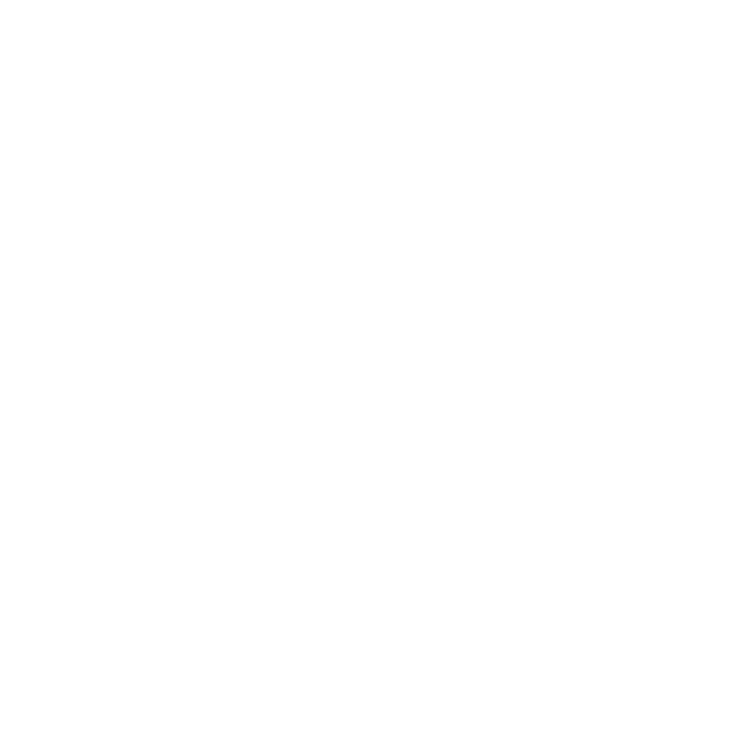

In [2]:
import csv
audio_path = 'time_traveler.mp3'
y, sr = librosa.load(audio_path, sr=None)

# Parameters
n_fft = 2048
hop_length = 512
fps = 60
duration = librosa.get_duration(y=y, sr=sr)
frames = int(duration * fps)

# Compute STFT, RMS energy, and spectral centroid
stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
rms_energy = librosa.feature.rms(S=stft).flatten()
spectral_centroid = librosa.feature.spectral_centroid(S=stft, sr=sr).flatten()

# Normalize RMS energy and spectral centroid
rms_energy /= rms_energy.max()
spectral_centroid /= spectral_centroid.max()

# Define sub-bands for bass, midtones, and treble (4 bands each)
bass_limits = np.linspace(20, 250, 5)
mid_limits = np.linspace(250, 2000, 5)
treble_limits = np.linspace(2000, 8000, 5)

# Compute onset strengths in each sub-band
bass_onsets = [
    librosa.onset.onset_strength(y=y, sr=sr, S=stft[(frequencies >= bass_limits[i]) & (frequencies < bass_limits[i+1]), :], hop_length=hop_length)
    for i in range(4)
]
mid_onsets = [
    librosa.onset.onset_strength(y=y, sr=sr, S=stft[(frequencies >= mid_limits[i]) & (frequencies < mid_limits[i+1]), :], hop_length=hop_length)
    for i in range(4)
]
treble_onsets = [
    librosa.onset.onset_strength(y=y, sr=sr, S=stft[(frequencies >= treble_limits[i]) & (frequencies < treble_limits[i+1]), :], hop_length=hop_length)
    for i in range(4)
]

# Normalize onset strengths to [0, 1] for brightness
bass_onsets = [onset / np.max(onset) if np.max(onset) > 0 else onset for onset in bass_onsets]
mid_onsets = [onset / np.max(onset) if np.max(onset) > 0 else onset for onset in mid_onsets]
treble_onsets = [onset / np.max(onset) if np.max(onset) > 0 else onset for onset in treble_onsets]

# LED configuration
led_positions = [(np.cos(2 * np.pi * i / 12), np.sin(2 * np.pi * i / 12)) for i in range(12)]
colors = ['red'] * 4 + ['green'] * 4 + ['blue'] * 4

# Initialize the plot
fig, ax = plt.subplots(figsize=(9.5, 9.5), dpi=100)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis("off")

# Initialize LED circles
led_circles = [Circle(pos, 0.1) for pos in led_positions]
for color, circle in zip(colors, led_circles):
    circle.set_facecolor(color)
    ax.add_patch(circle)

# Parameters for smooth transitions and scaling
smoothing_alpha = 0.8  # Smoothing factor for exponential moving average
previous_brightness = [0] * 12  # Initialize brightness history for smoothing
low_energy_threshold = 0.55  # Threshold for applying smoothing

# Function to apply logarithmic scaling
def log_scale(x, factor=4):
    return np.log1p(x * factor)# / np.log1p(factor)

# Initialize CSV data storage
csv_data = []

# Function to draw each frame and save RGB values
for frame_idx in range(frames):
    t = frame_idx / fps  # Convert frame index to time
    onset_idx = int(t * sr / hop_length)

    # Adjust brightness scaling with energy and spectral centroid
    energy_scale = rms_energy[onset_idx] if onset_idx < len(rms_energy) else 0.5
    centroid_scale = spectral_centroid[onset_idx] if onset_idx < len(spectral_centroid) else 0.5
    brightness_scale = log_scale(energy_scale * 0.8 + centroid_scale * 0.4)

    # Separate lists to store RGB values for each color group in this frame
    red_led_values = []
    green_led_values = []
    blue_led_values = []

    # Update LED brightness based on onset strength
    for i in range(4):
        # Bass (red LEDs)
        bass_alpha = bass_onsets[i][onset_idx] if onset_idx < len(bass_onsets[i]) else 0
        target_brightness = log_scale(bass_alpha * brightness_scale)

        # Apply smoothing only if in a low-energy section
        if energy_scale < low_energy_threshold:
            smoothed_brightness = smoothing_alpha * previous_brightness[i] + (1 - smoothing_alpha) * target_brightness
        else:
            smoothed_brightness = target_brightness  # No smoothing for high-energy sections

        led_circles[i].set_alpha(min(1, smoothed_brightness))
        previous_brightness[i] = smoothed_brightness

        # Set RGB for red LED and append to red_led_values
        red_value = min(255,int(smoothed_brightness * 255))
        red_led_values.append(f"{red_value},0,0")

        # Midtones (green LEDs)
        mid_alpha = mid_onsets[i][onset_idx] if onset_idx < len(mid_onsets[i]) else 0
        target_brightness = log_scale(mid_alpha * brightness_scale)
        if energy_scale < low_energy_threshold:
            smoothed_brightness = smoothing_alpha * previous_brightness[i + 4] + (1 - smoothing_alpha) * target_brightness
        else:
            smoothed_brightness = target_brightness

        led_circles[i + 4].set_alpha(min(1, smoothed_brightness))
        previous_brightness[i + 4] = smoothed_brightness

        # Set RGB for green LED and append to green_led_values
        green_value = min(255,int(smoothed_brightness * 255))
        green_led_values.append(f"0,{green_value},0")

        # Treble (blue LEDs)
        treble_alpha = treble_onsets[i][onset_idx] if onset_idx < len(treble_onsets[i]) else 0
        target_brightness = log_scale(treble_alpha * brightness_scale)
        if energy_scale < low_energy_threshold:
            smoothed_brightness = smoothing_alpha * previous_brightness[i + 8] + (1 - smoothing_alpha) * target_brightness
        else:
            smoothed_brightness = target_brightness

        led_circles[i + 8].set_alpha(min(1, smoothed_brightness))
        previous_brightness[i + 8] = smoothed_brightness

        # Set RGB for blue LED and append to blue_led_values
        blue_value = min(255,int(smoothed_brightness * 255))
        blue_led_values.append(f"0,0,{blue_value}")

    # Combine red, green, and blue values in the correct order
    frame_rgb_values = red_led_values + green_led_values + blue_led_values
        
    # Append the RGB values for the frame to csv_data
    frame_rgb_values.append(t)
    csv_data.append(frame_rgb_values)

# Save RGB data and timestamp to CSV
csv_header = [f"LED_{i}" for i in range(12)] + ['t']
csv_filename = "time_traveler_program.csv"

with open(csv_filename, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_header)  # Write the header
    writer.writerows(csv_data)   # Write the RGB data for each frame


In [18]:
onset_idx

18689